### BNC Challenge 2008 課題の前後でのチャンネル同士のコネクティビティの変化
[Development of Global Cortical Networks in Early Infancy](http://www.jneurosci.org/content/30/14/4877)を参考に

検定の流れは
+ １人の被験者につき代表値を462(22ch×21ch)個（タスク別に）算出
+ 横軸にイベント、縦軸にzスコアをとり９人それぞれの点をプロット
+ この図についてt検定
+ p値ではなくFDRを考慮したq値で優位差を判断

In [60]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.signal import correlate
from scipy.stats import zscore, norm, ttest_rel
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="whitegrid", color_codes=True)
import mne
from mne.connectivity import spectral_connectivity
import itertools

In [2]:
event_id = dict(left_hand=1, right_hand=2, feet=3, tongue=4)  # event ID

In [3]:
fs = 250 # Sampling frequency
info = mne.create_info(["ch"+str(i) for i in range(25)], fs) #  Channel labels and sampling freq.

In [4]:
# Read events from csv
subjects = ['A01T', 'A02T', 'A03T', 'A04T', 'A05T', 'A06T', 'A07T', 'A08T', 'A09T']
#subjects = ['A01T', 'A02T', 'A03T']
#events = [0] * len(subjects)
#eegs = [0] * len(subjects)
#raw = [0] * len(subjects)
epochs = [0] * len(subjects)
#cm_post = [0] * len(subjects)
#cm_binary = [0] * len(subjects)
#one_cm = [0] * len(subjects)
#cm_pre = [0] * len(subjects)
#cm_pre_binary = [0] * len(subjects)

In [5]:
for (i, subject) in enumerate(subjects):
    events = pd.read_csv('./datasets/events_'+subject+'.csv', header=None)
    events = np.array(events.astype(int))
    eegs = pd.read_csv('./datasets/eeg_'+subject+'.csv', header=None)
    raw = mne.io.array.RawArray(eegs, info)
    epochs[i] = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=6.0, baseline=(None,0), preload=True, add_eeg_ref=False)

Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading

波形を平均してから相関係数を出すのもやってみました。
ただ相関係数の平均と比べてかなり値が変わるのと、BCIを研究していた人に聞いたら、BCIでは波形を平均したものを扱うことはめったにないそうなので、従来通り相関係数の平均でいいのかなという印象です。

In [58]:
# culculate coef by mean_eeg
'''def calc_mean_coef_z(epochs, event, pre, ch1, ch2):
    if(pre):
        signal = epochs[event].get_data()[:,[ch1,ch2],0:500].mean(0)
    else:
        signal = epochs[event].get_data()[:,[ch1,ch2],750:1250].mean(0)
    coef = max(correlate(signal[0,:], signal[1,:])) / (np.linalg.norm(signal[0,:])*np.linalg.norm(signal[1,:]))
    #mean_r = np.array(coefs).mean()
    # Fisher's z transformation
    z_score = np.arctanh(coef)
    return z_score'''

"def calc_mean_coef_z(epochs, event, pre, ch1, ch2):\n    if(pre):\n        signal = epochs[event].get_data()[:,[ch1,ch2],0:500].mean(0)\n    else:\n        signal = epochs[event].get_data()[:,[ch1,ch2],750:1250].mean(0)\n    coef = max(correlate(signal[0,:], signal[1,:])) / (np.linalg.norm(signal[0,:])*np.linalg.norm(signal[1,:]))\n    #mean_r = np.array(coefs).mean()\n    # Fisher's z transformation\n    z_score = np.arctanh(coef)\n    return z_score"

In [7]:
def calc_mean_coef_z(epochs, event, ch1, ch2):
    signal = epochs[event].get_data()[:,[ch1,ch2],750:1250]
    trial_num = signal.shape[0]
    coefs = [max(correlate(signal[trial,0,:], signal[trial,1,:])) / (np.linalg.norm(signal[trial,0,:])*np.linalg.norm(signal[trial,1,:])) for trial in range(trial_num)]
    mean_r = np.array(coefs).mean()
    # Fisher's z transformation
    z_score = np.arctanh(mean_r)
    return z_score

In [8]:
# 0612イベント間での検定ができるように改定 
def make_comparable_data(epochs, event1, event2, ch1, ch2):
    data = {event1:[], event2:[]}
    for i in range(len(epochs)):
        data[event1].append(calc_mean_coef_z(epochs[i], event1, ch1, ch2))
        data[event2].append(calc_mean_coef_z(epochs[i], event2, ch1, ch2))
        title = "{0}-{1} ch{2}-ch{3}".format(event1, event2, ch1, ch2)
    df = pd.DataFrame(data)
    return df, event1, event2, title

In [9]:
def df2sns(df, event1, event2):
    data = {"z_score":[], "condition":[]}
    for ix, row in df.iterrows():
        data['z_score'].append(row[event1])
        data['z_score'].append(row[event2])
        data['condition'].append(event1)
        data['condition'].append(event2)
    return pd.DataFrame(data)

In [10]:
def srs2sns(series, event1, event2):
    data = {"z_score":[], "condition":[event1, event2]}
    data['z_score'].append(series[event1])
    data['z_score'].append(series[event2])
    return pd.DataFrame(data)

例えば、左手条件でのch10-ch11間の相関係数の差を９人で検定することを考える

In [11]:
df, event1, event2, title = make_comparable_data(epochs, "left_hand", "right_hand", 10,11)
df

,left_hand,right_hand
0,1.900219,1.875148
1,1.886598,1.891977
2,1.888672,1.884943
3,1.778253,1.722216
4,1.899932,1.876259
5,1.652200,1.593346
6,1.753118,1.739840
7,1.995258,1.771375
8,1.790768,1.524944


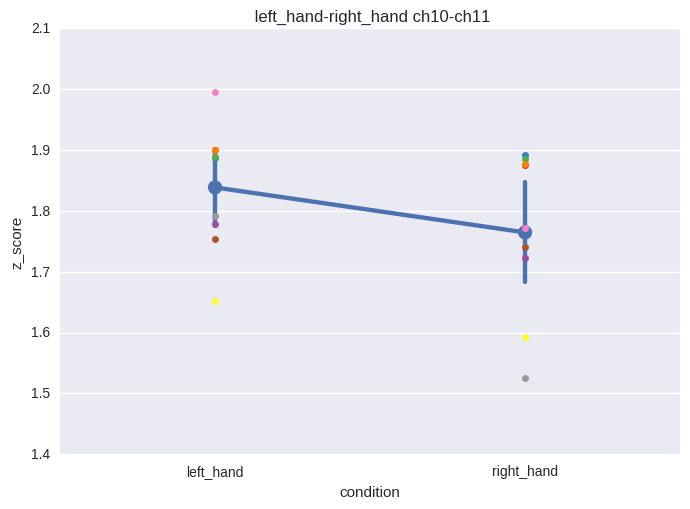

In [12]:
ax = sns.pointplot("condition", y="z_score", data=df2sns(df, event1, event2))
palette = sns.color_palette("Set1", n_colors=len(df))
for i in range(len(df)):
    data = srs2sns(df.ix[i], event1, event2)
    sns.stripplot(x="condition", y="z_score", data=data, color=palette[i])
ax.set_title(" "+title)

In [13]:
t, p = ttest_rel(df[event1], df[event2])
print("p = {0}".format(p))

p = 0.0570756762660494


この要領で6条件×（21ｃｈ×21ｃｈ）の組み合わせを全通り検定する
+ rhand-lhand
+ rhand-foot
+ rhand-tongue
+ lhand-foot
+ lhand-tongue
+ foot-tongue

In [14]:
def test_corr(epochs, event1, event2, ch1, ch2):
    df, event1, event2, title = make_comparable_data(epochs, event1, event2, ch1, ch2)
    t, p = ttest_rel(df[event1], df[event2])
    return p

In [15]:
results = {}
ch_num = 22
for event1, event2 in itertools.combinations(event_id.keys(),2):
    for ch1,ch2 in itertools.combinations(range(ch_num),2):
            p = test_corr(epochs, event1, event2, ch1, ch2)
            results["{0}-{1}_ch{2}-ch{3}".format(event1, event2, ch1, ch2)] = p

In [16]:
# False Discovery Rateを考慮した検定
reject, q_value,_,_ = multipletests(list(results.values()), alpha=0.1, method="fdr_tsbky")

In [17]:
for i, (condition, p_value) in enumerate(results.items()):
    if(reject[i]):
        print("{0} q={1}".format(condition, q_value[i]))

tongue-right_hand_ch17-ch18 q=0.07042813087968013
tongue-left_hand_ch2-ch19 q=0.04719585241507853
tongue-right_hand_ch16-ch18 q=0.08159738974649473
feet-left_hand_ch0-ch8 q=0.055417033714284206
tongue-left_hand_ch16-ch17 q=0.06883470563251227
tongue-feet_ch17-ch18 q=0.09134969942592691
tongue-right_hand_ch0-ch6 q=0.06538936776009074
right_hand-feet_ch0-ch8 q=0.05560254405994242
tongue-left_hand_ch4-ch21 q=0.07123340138452157
tongue-left_hand_ch17-ch20 q=0.0675725794917623
feet-left_hand_ch5-ch11 q=0.05763258676101822
tongue-left_hand_ch11-ch16 q=0.08367949082840843
right_hand-feet_ch7-ch10 q=0.09134969942592691
tongue-feet_ch4-ch10 q=0.048192045779187245
tongue-right_hand_ch3-ch16 q=0.048192045779187245
tongue-feet_ch7-ch16 q=0.055417033714284206
right_hand-left_hand_ch1-ch20 q=0.05591150809454203
tongue-right_hand_ch0-ch21 q=0.08159738974649473
tongue-right_hand_ch11-ch17 q=0.09639437009927668
right_hand-feet_ch10-ch13 q=0.060529056613294156
tongue-right_hand_ch8-ch15 q=0.060457987645

In [18]:
def plot_corr(epochs, event1, event2, ch1, ch2):
    df, event1, event2, title = make_comparable_data(epochs, event1, event2, ch1, ch2)
    ax = sns.pointplot("condition", y="z_score", data=df2sns(df, event1, event2))
    palette = sns.color_palette("Set1", n_colors=len(df))
    for i in range(len(df)):
        data = srs2sns(df.ix[i], event1, event2)
        sns.stripplot(x="condition", y="z_score", data=data, color=palette[i])
    ax.set_title(" "+title)

有意差がでたチャンネルの組み合わせ

図を見ると信頼区間が重なっていますが、それでも有意差が出るときはあるようです

参考 [http://id.fnshr.info/2014/12/17/stats-done-wrong-06/](http://id.fnshr.info/2014/12/17/stats-done-wrong-06/)

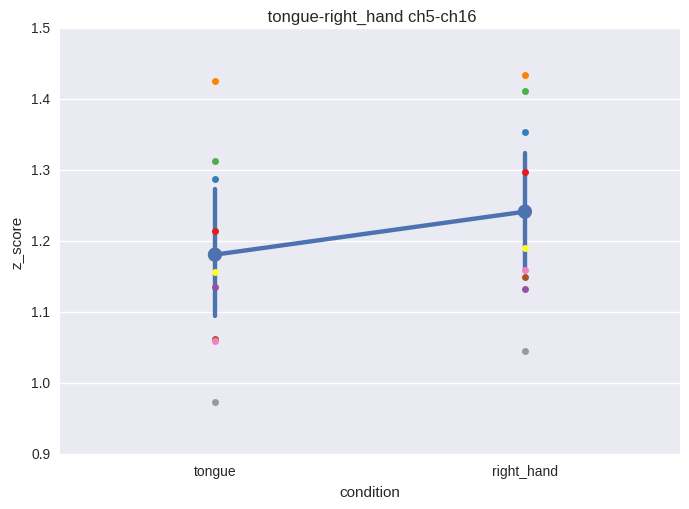

In [19]:
plot_corr(epochs, "tongue", "right_hand", 5, 16)

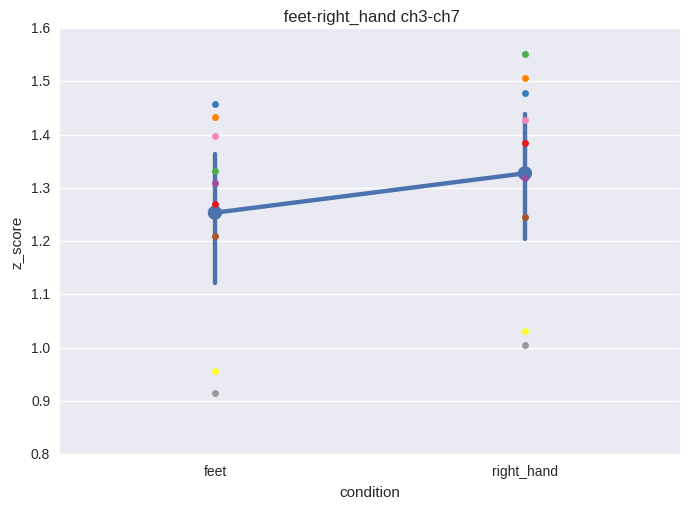

In [20]:
plot_corr(epochs, "feet", "right_hand", 3, 7)

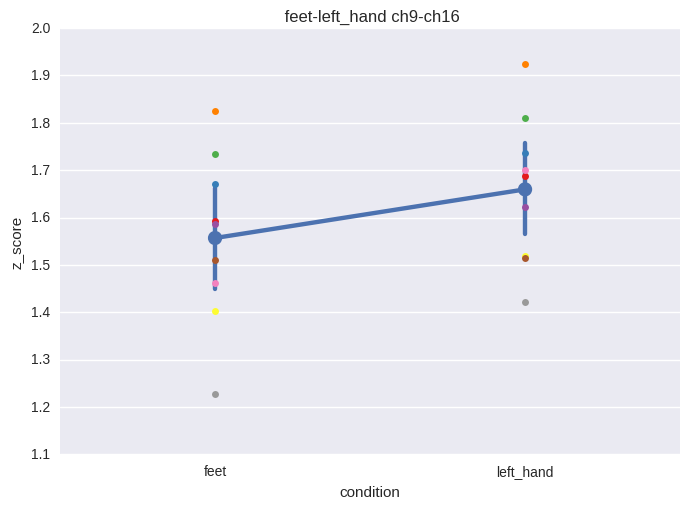

In [21]:
plot_corr(epochs, "feet", "left_hand", 9, 16)

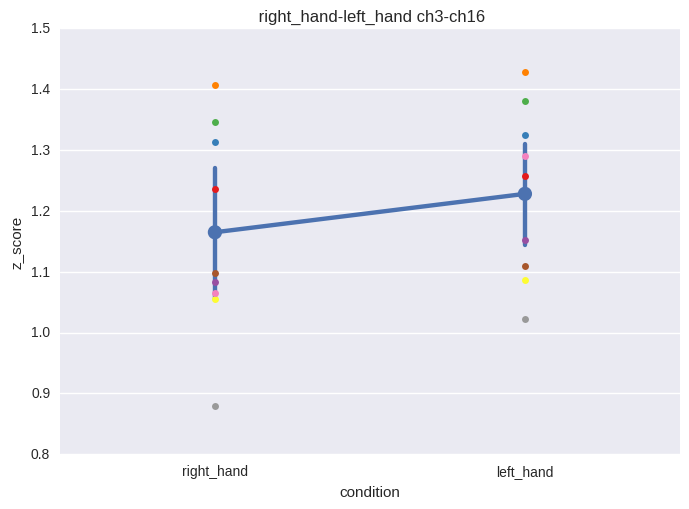

In [22]:
plot_corr(epochs, "right_hand", "left_hand", 3, 16)

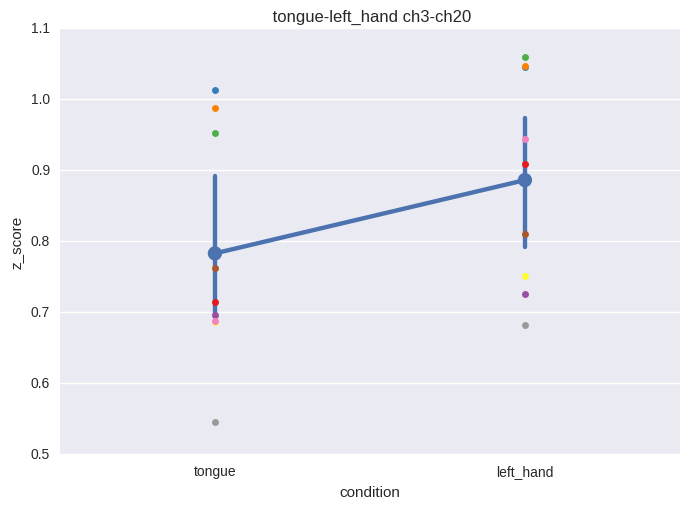

In [23]:
plot_corr(epochs, "tongue", "left_hand", 3, 20)

### 分類器の作成

In [117]:
# 教師データ
y_train = []
for epoch in epochs[:1]:
    y_train = y_train + list(epoch.events[:,2])
len(y_train)

336

In [47]:
def get_corarr(signal):
    ch_num = 22
    corarr = []
    for ch1,ch2 in itertools.combinations(range(ch_num),2):
        r = max(correlate(signal[ch1], signal[ch2])) / (np.linalg.norm(signal[ch1])*np.linalg.norm(signal[ch2]))
        if r < 0.95:
            val = 0
        else:
            val = 1
        corarr.append(r)
    return corarr

In [113]:
# 学習データ
X_train = []
for epoch in epochs[:1]:
    for signals in epoch.get_data():
        colvec = np.array(get_corarr(signals[:,750:1250]))
        colvec_normed = (colvec - colvec.mean()) / colvec.std()
        X_train.append(colvec_normed)
len(X_train)

336

In [114]:
from sklearn import svm
clf = svm.SVC(C=100, cache_size=200, class_weight="balanced", \
                          coef0=0.0, gamma="auto", kernel="rbf", \
                          max_iter=-1, probability=False,random_state=None, \
                          shrinking=True, tol=0.001, verbose=False, decision_function_shape='ovr')

まずは交差検定法による精度測定

In [124]:
from sklearn import cross_validation
Xc_train, Xc_test, yc_train, yc_test = cross_validation.train_test_split(X_train, y_train, test_size=0.4, random_state=None)
clf.fit(Xc_train, yc_train)
print(clf.score(Xc_test, yc_test))

0.622222222222


テスト用データの読み込み

In [29]:
subjects = ['A01E', 'A02E', 'A03E', 'A04E', 'A05E', 'A06E', 'A07E', 'A08E', 'A09E']
epochs_test = [0] * len(subjects)
for (i, subject) in enumerate(subjects):
    events = pd.read_csv('./datasets/events_'+subject+'.csv', header=None)
    events = np.array(events.astype(int))
    eegs = pd.read_csv('./datasets/eeg_'+subject+'.csv', header=None)
    raw = mne.io.array.RawArray(eegs, info)
    epochs_test[i] = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=6.0, baseline=(None,0), preload=True, add_eeg_ref=False)

Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading

In [76]:
# 正解データ
y_test = []
for epoch in epochs_test:
    y_test = y_test + list(epoch.events[:,2])
len(y_test)

3024

In [74]:
# テストデータ
X_test = []
for epoch in epochs_test:
    for signals in epoch.get_data():
        colvec = np.array(get_corarr(signals[:,750:1250]))
        colvec_normed = (colvec - colvec.mean()) / colvec.std()
        X_test.append(colvec_normed)
len(X_test)

3024

In [87]:
clf.score(X_test, y_test)

0.41699735449735448